# 2) Targeted FGSM (Linf)

## 2.1) Preparation

In [1]:
from utils import *
import torch
from models.blip import blip_decoder
from torchmetrics.functional.image import peak_signal_noise_ratio

In [2]:
# set hyperparameters
IMG_SIZE = 384
MODEL_PATH = "./pretrained_weights/model_base_caption_capfilt_large.pth"
IMG_PATH = "./imgs/demo.jpg"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Selected device: {DEVICE.type}")

Selected device: cuda


In [3]:
# prepare the img
img = preprocess_img(IMG_PATH, IMG_SIZE)
img = img.to(DEVICE)
img_norm = normalize(img)

In [4]:
# load BLIP image-to-caption model
model = blip_decoder(pretrained=MODEL_PATH, image_size=IMG_SIZE, vit='base')
model.eval()
model = model.to(DEVICE)

load checkpoint from ./pretrained_wights/model_base_caption_capfilt_large.pth


## 2.2) Changing a Single Word in the Caption

In [5]:
orig_caption   = "a woman sitting on the beach with a dog"
target_caption = "a man sitting on the beach with a dog"

with torch.no_grad():
    orig_loss = model(img_norm, model.prompt + orig_caption)
    target_loss = model(img_norm, model.prompt + target_caption)
    print(f"Orig caption  : {orig_caption}, loss: {orig_loss.item():.3f}")
    print(f"Target caption: {target_caption}, loss: {target_loss.item():.3f}")

Orig caption  : a woman sitting on the beach with a dog, loss: 1.853
Target caption: a man sitting on the beach with a dog, loss: 2.446


![formula](./assets/formulas/2.png)

In [6]:
epsilon=0.006  # maximum L-infinity norm of the adversarial perturbation

clone_img = img.clone()
clone_img.requires_grad = True

loss = model(normalize(clone_img), model.prompt + target_caption)  # forward pass

# clear grad 
if clone_img.grad is not None:
    clone_img.grad.zero_()

loss.backward()  # backprop

adv_img = clone_img - epsilon * clone_img.grad.sign()  # move towards the opposite direction of the gradient's sign (steepest descent)

adv_img.clamp_(0, 1)  # clip pixel values to the valid range of [0, 1]

adv_img = adv_img.detach()  # detach adv_img from the computation graph
adv_img_norm = normalize(adv_img)

In [7]:
with torch.no_grad():
    orig_loss = model(adv_img_norm, model.prompt + orig_caption)
    target_loss = model(adv_img_norm, model.prompt + target_caption)
    print(f"Orig caption  : {orig_caption}, loss: {orig_loss.item():.3f}")
    print(f"Target caption: {target_caption}, loss: {target_loss.item():.3f}")

Orig caption  : a woman sitting on the beach with a dog, loss: 2.014
Target caption: a man sitting on the beach with a dog, loss: 1.909


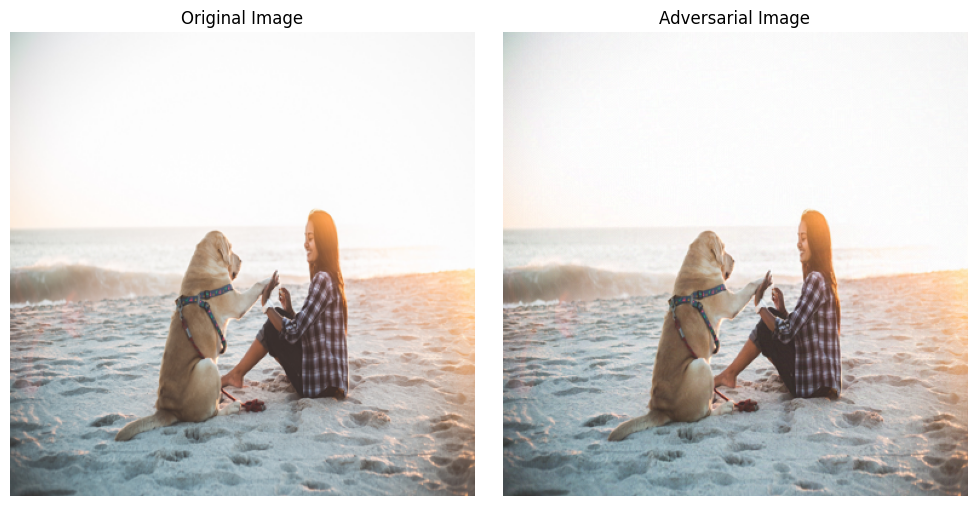

In [8]:
display_img(orig_img_tensor=img, adv_img_tensor=adv_img)

In [9]:
with torch.no_grad():
    caption = model.generate(adv_img_norm, sample=False, num_beams=3, max_length=20, min_length=5)[0]
    print("Caption generated from adversarial image:")
    print("  " + caption)

Caption generated from adversarial image:
  a man sitting on the beach with a dog


In [12]:
psnr_value = peak_signal_noise_ratio(adv_img, img).item()
print(f"PSNR: {psnr_value:.2f} dB")

PSNR: 43.16 dB


In [13]:
save_path = "./imgs/adv_img_FGSM.png"  # SAVE ONLY IN PNG FORMAT

# save the adversarial image
save_img(adv_img, save_path)

# load the saved image and preprocess it
saved_img = preprocess_img(save_path, IMG_SIZE)
saved_img = saved_img.to(DEVICE)
saved_img_norm = normalize(saved_img)

# check the caption
with torch.no_grad():
    caption = model.generate(saved_img_norm, sample=False, num_beams=3, max_length=20, min_length=5)[0]
    print("\nCaption generated from adversarial image:")
    print("  " + caption)

# check the PSNR
psnr_value = peak_signal_noise_ratio(saved_img, img).item()
print(f"\nPSNR: {psnr_value:.2f} dB (lower due to saving the image in 8-bit format)")

Image saved. Number of out of range data: 0

Caption generated from adversarial image:
  a man sitting on the beach with a dog

PSNR: 42.83 dB (lower due to saving the image in 8-bit format)
